In [1]:
#import modules
%pylab inline

from astropy.cosmology import Planck13
from astropy.io import fits
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
random.seed(12345)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

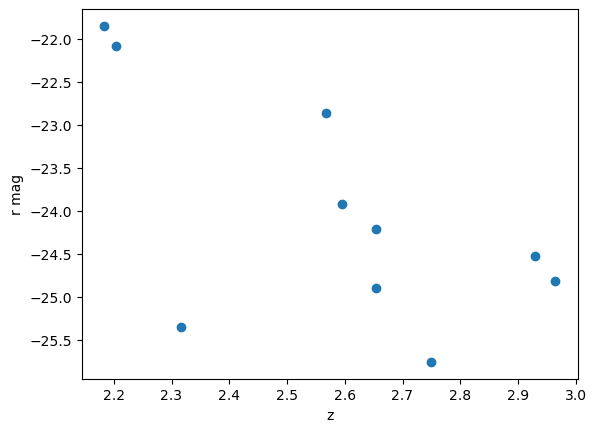

In [3]:
# randomly assigning magnitude and redshift points
nqso = 10 #number of quasars
zin = 2.0 + np.random.rand(nqso)
# fixed magnitude and redshift points
#M = AbsMagVar(FixedSampler(linspace(-27,-25,nqso)[::-1]),restWave=1450)
#z = RedshiftVar(FixedSampler(linspace(2,4,nqso)))
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (15,23),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.absMag)
xlabel('z')
ylabel('r mag');


In [4]:
sedVars = get_BossDr9_model_vars(qsos,wave,0,forestseed=192837465,verbose=1)
qsos.addVars(sedVars)

Generating 10 sightlines


In [5]:
# add two dust components as in Lyu+Rieke 2017, but reduce the hot dust flux by a factor of 2
#subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
#                               name='sublimdust')
#subDustVar.set_associated_var(contVar)
#hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
#                               name='hotdust')
#hotDustVar.set_associated_var(contVar)
#contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),
#                                      GaussianSampler(-0.5,0.3)],
#                                     [1215.])


In [6]:
# generate lines using the Baldwin Effect emission line model from BOSS DR9
#emLineVar = generateBEffEmissionLines(qsos.absMag)

In [7]:
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
#fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
#feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=fescales))

In [8]:
# Now add the features to the QSO grid
#qsos.addVars([contVar,subDustVar,hotDustVar,emLineVar,feVar])

Simulation of n number of Quasars

In [9]:
# simulation
qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.2257979, rms = 0.0310515, |max| = 0.2751364
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0198071, rms = 0.0131860, |max| = 0.0407771
buildSpectra iteration  3  out of  3
--> delta mag mean = -0.0005661, rms = 0.0005477, |max| = 0.0016140


In [10]:
# data set
qsos.data

absMag,appMag,z,slopes,emLines,igmlos,synMag,synFlux
float32,float32,float32,float32[5],"float32[62,3]",int32,float32[5],float32[5]
-24.20842,20.961443,2.929616,-1.239317 .. -0.51432467,1034.0386 .. 288.20486,0,20.469534 .. 20.161724,6.4891305 .. 8.616098
-25.138588,19.616411,2.3163755,-1.5465738 .. -0.7295905,1033.7485 .. 304.23578,1,19.639774 .. 18.210718,13.934474 .. 51.9652
-21.569447,22.982542,2.1839187,-2.0657601 .. -1.0652694,1034.8862 .. 303.59912,2,22.930632 .. 21.410748,0.6725856 .. 2.7271
-21.909758,22.773327,2.2045603,-1.3661616 .. -1.5135577,1034.5219 .. 261.10162,3,22.683014 .. 21.627903,0.8448789 .. 2.232745
-22.62311,22.330471,2.567725,-1.7431798 .. -1.4066138,1034.025 .. 292.39233,4,22.232069 .. 21.068195,1.2798903 .. 3.7387085
-23.700573,21.299658,2.5955448,-1.2690649 .. -0.8752623,1033.4799 .. 314.51462,5,21.066898 .. 20.081015,3.7431793 .. 9.280983
-24.546402,20.694876,2.9645145,-1.5791516 .. -1.4559236,1034.5442 .. 249.95755,6,20.19321 .. 20.077187,8.369818 .. 9.313765
-24.640106,20.379028,2.653177,-1.314679 .. -0.46566364,1033.0952 .. 294.6547,7,20.331556 .. 19.423998,7.3684745 .. 16.998112
-25.49065,19.592901,2.7489066,-1.680283 .. -1.3772606,1033.1836 .. 430.3107,8,19.119965 .. 18.703236,22.491291 .. 33.014606


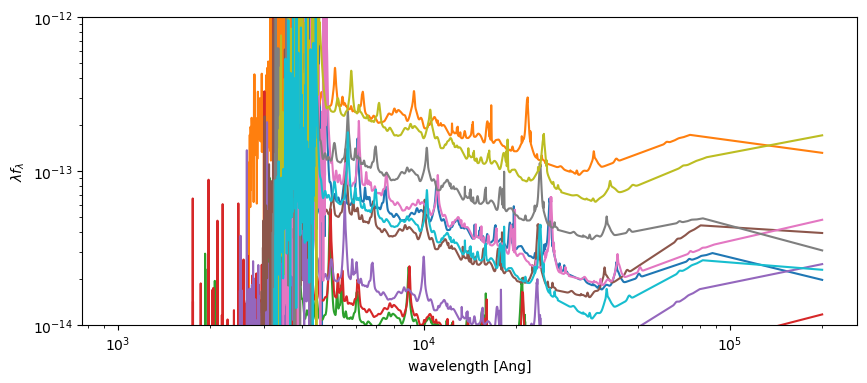

In [11]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

(3000.0, 5500.0)

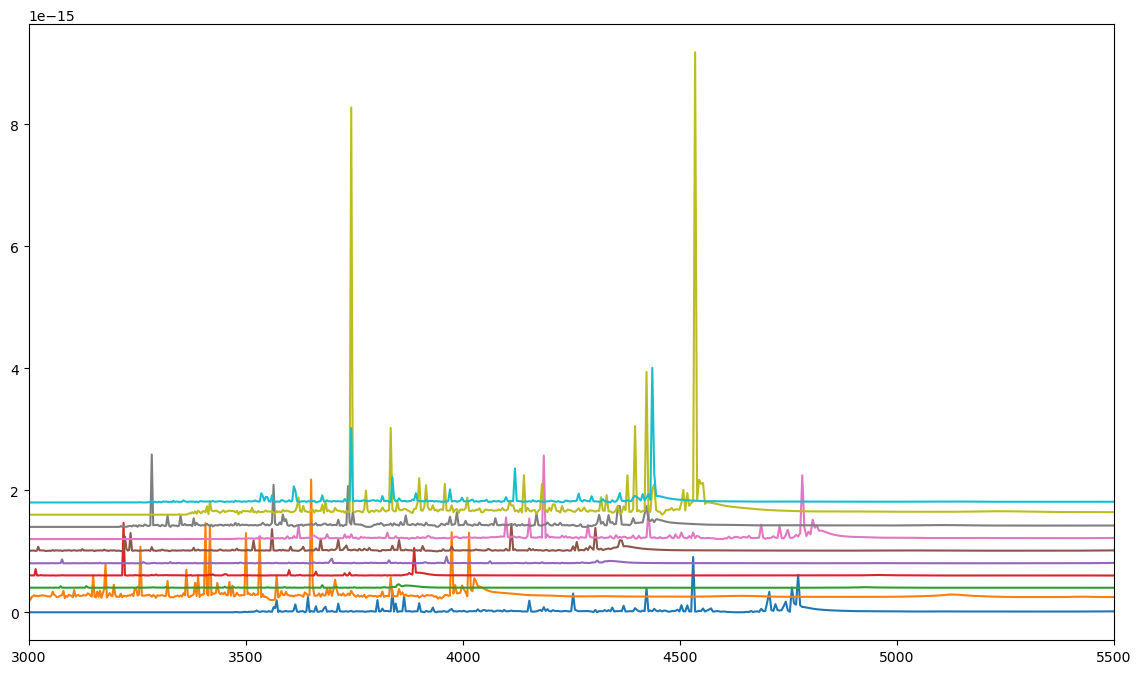

In [12]:
figure(figsize=(14,8))
for i,sp in enumerate(spectra):
    plot(wave,sp+i*2e-16)
xlim(3000,5500)

In [13]:
# compare the resulting SEDs to the mean SED from Lyu+Rieke 2017
from astropy.table import Table
try:
    lr17 = Table.read('apjaa7051t4_mrt.txt',format='ascii')
    lr17wave = array(10**lr17['lambda'])
    lamflam = array(spectra)*wave
    figure(figsize=(8,4))
    for i,z in enumerate(qsos.data['z']):
        j = searchsorted(wave/(1+z),5100)
        fscl = 1/lamflam[i,j]
        plot(wave/(1+z)/1e4,log10(fscl*lamflam[i]))
    j = searchsorted(lr17wave,0.51)
    fscl = lr17['LogL-Norm'][j]
    plot(lr17wave,lr17['LogL-Norm']-fscl,c='k')
    axvline(0.51,c='gray',ls='--')
    xlim(0.1,5)
    ylim(-1,1)
    xscale('log');
except IOError:
    pass

Divide the spectrum into components. Offset the emission line and iron template features for clarity.

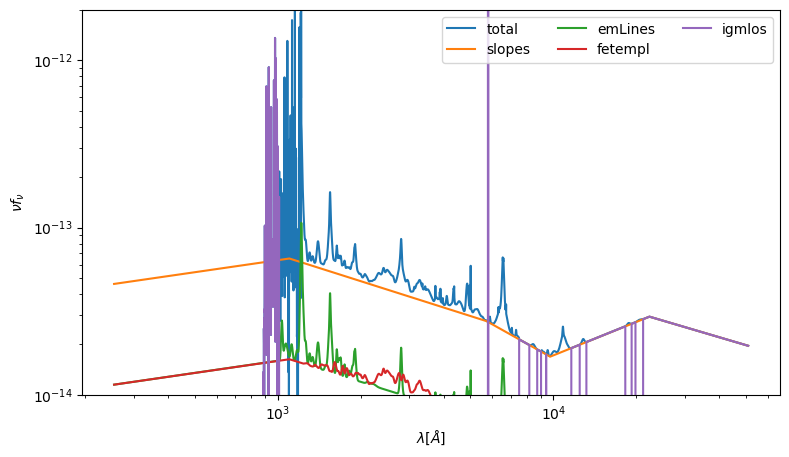

In [14]:
sp,comp = buildQsoSpectrum(wave,qsos.cosmo,qsos.getVars(SpectralFeatureVar),
                           qsos.data[0],save_components=True)
z1 = sp.z + 1
figure(figsize=(9,5))
plot(sp.wave/z1,sp.wave*sp.f_lambda,label='total')
for cname,cspec in comp.items():
    flam = cspec.f_lambda
    if cname in ['emLines','fetempl']:
        flam = 0.25*comp['slopes'].f_lambda*(1+flam)
    plot(cspec.wave/z1,cspec.wave*flam,label=cname)
legend(ncol=3)
ylim(1e-14,2e-12)
xscale('log')
yscale('log')
xlabel('$\lambda [\AA]$')
ylabel(r'$\nu{f}_\nu$');

In [15]:
qsos.write('quasar1_meta',extname='quasar1',overwrite=True)

In [16]:
ff = fits.open('quasar1_meta.fits')
ff.info()

Filename: quasar1_meta.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  QUASAR1       1 BinTableHDU     69   10R x 8C   [E, E, E, 5E, 186E, J, 5E, 5E]   


In [17]:
save_spectra(wave,spectra,'quasar1')

In [18]:
wave,spec = load_spectra('quasar1')

In [19]:
qsos_restore = restore_qso_grid('quasar1_meta',wave,extname='quasar1')

In [20]:
specs0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

absMag,appMag,z,slopes,emLines,igmlos,synMag,synFlux
float32,float32,float32,float32[5],"float32[62,3]",int32,float32[5],float32[5]
-24.20842,20.961443,2.929616,-1.239317 .. -0.51432467,1034.0386 .. 288.20486,0,20.469534 .. 20.161724,6.4891305 .. 8.616098


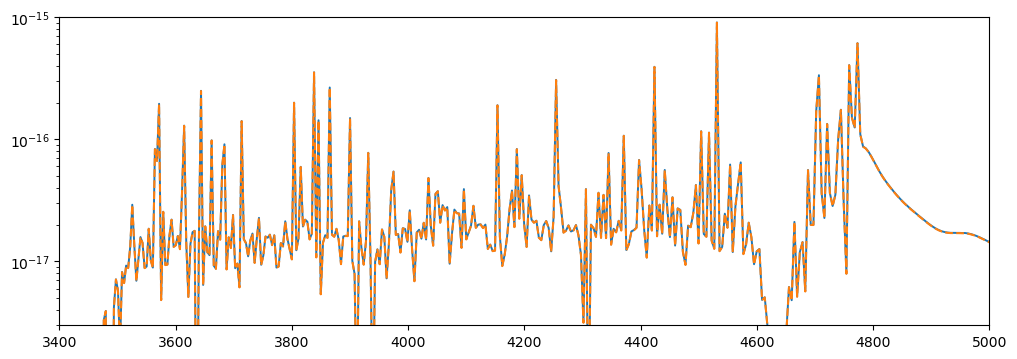

In [21]:
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,specs0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-16)
xlim(3400,5000);#1e4);
qsos.data[0]

In [22]:
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

absMag,appMag,z,slopes,emLines,igmlos,synMag,synFlux
float32,float32,float32,float32[5],"float32[62,3]",int32,float32[5],float32[5]
-25.138588,19.616411,2.3163755,-1.5465738 .. -0.7295905,1033.7485 .. 304.23578,1,19.639774 .. 18.210718,13.934474 .. 51.9652


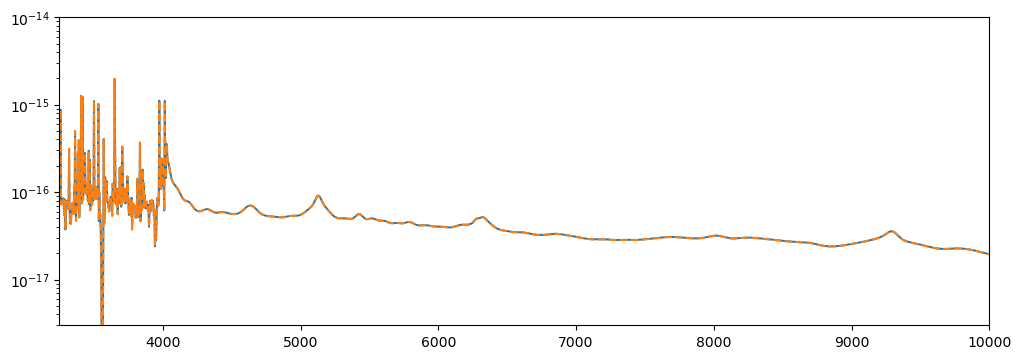

In [23]:
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-15)
xlim(3250,1e4);
qsos.data[1]

In [24]:
_,allspec = buildSpectraBulk(wave,qsos_restore)

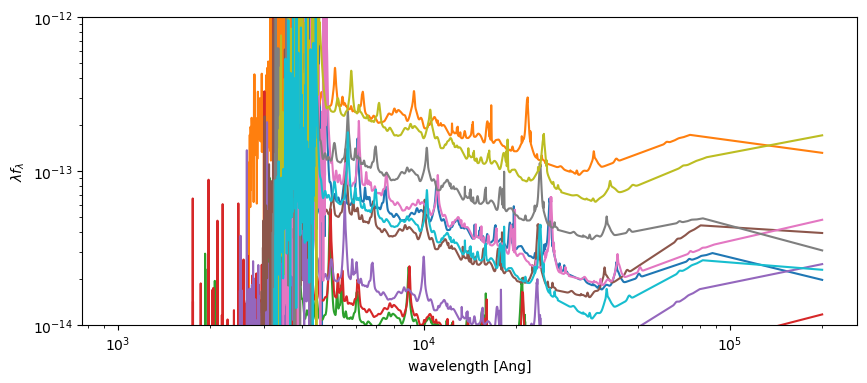

In [25]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

In [26]:
spec2 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[2])

absMag,appMag,z,slopes,emLines,igmlos,synMag,synFlux
float32,float32,float32,float32[5],"float32[62,3]",int32,float32[5],float32[5]
-21.569447,22.982542,2.1839187,-2.0657601 .. -1.0652694,1034.8862 .. 303.59912,2,22.930632 .. 21.410748,0.6725856 .. 2.7271


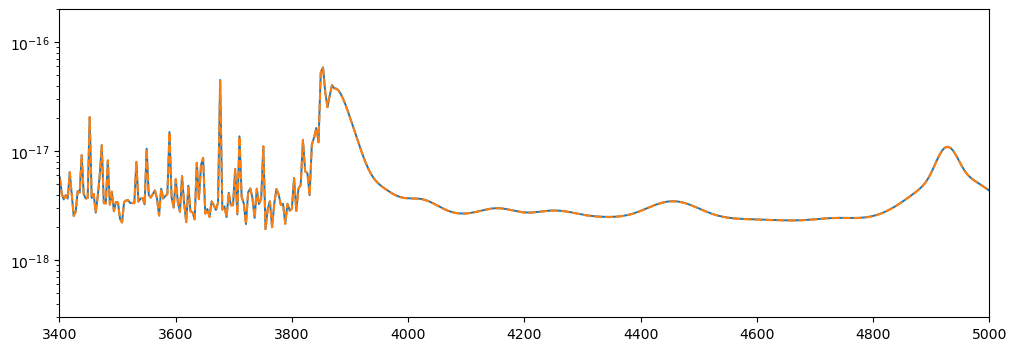

In [27]:
figure(figsize=(12,4))
plot(wave,spectra[2],lw=1.4)
plot(wave,spec2.f_lambda,ls='--')
yscale('log')
ylim(3e-19,2e-16)
xlim(3400,5000);#1e4);
qsos.data[2]

In [28]:
spec3 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[3])

absMag,appMag,z,slopes,emLines,igmlos,synMag,synFlux
float32,float32,float32,float32[5],"float32[62,3]",int32,float32[5],float32[5]
-21.909758,22.773327,2.2045603,-1.3661616 .. -1.5135577,1034.5219 .. 261.10162,3,22.683014 .. 21.627903,0.8448789 .. 2.232745


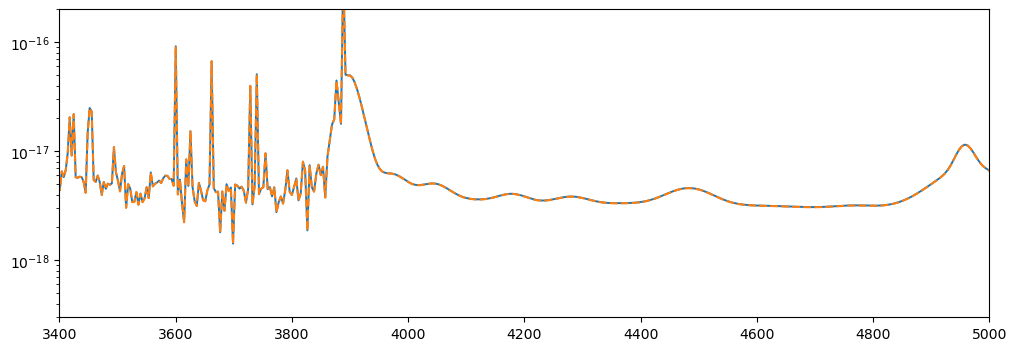

In [29]:
figure(figsize=(12,4))
plot(wave,spectra[3],lw=1.4)
plot(wave,spec3.f_lambda,ls='--')
yscale('log')
ylim(3e-19,2e-16)
xlim(3400,5000);#1e4);
qsos.data[3]